In [15]:
#Installing the necessary libraries
!pip install shap
!pip install contractions

In [16]:
import pandas as pd
import numpy as np

import shap
shap.initjs()

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
#from sklearn import preprocessing, model_selection,feature_extraction,linear_model, tree, neighbors, ensemble, svm, metrics, pipeline, decomposition

import contractions
import textblob
import re, string, unicodedata

from tqdm import tqdm

#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from typing import Tuple
import copy as cp

import nltk
nltk.download('all')


# Load data
DataPath= "C:/Users/Home/OneDrive - Teesside University/Dissertation/Datasets/Suicide_Detection.csv/Suicide_Detection.csv"
data = pd.read_csv(DataPath)



[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

In [17]:
data.shape

(232074, 3)

In [18]:
data.dropna(how='all')

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [19]:
Suicide_data_raw= data[['class', 'text']]
Suicide_data_raw.sample(5, random_state= 2)

,class,text
115313,suicide,You.‍‍‍‍I feel I deserve nothing. How many liv...
78611,suicide,Laters whoever knows me via this accountI’m cu...
199074,suicide,"Telling my best friend..I need help, how do i ..."
112519,non-suicide,unpopular opinion. Murder is wrong. Murderers ...
160158,suicide,Going to hang myself sitting downI have a rope...


In [20]:
df_suicide=Suicide_data_raw.sample(frac= 0.10) #Randomly selecting 10% of the dataset

In [21]:
df_suicide

,class,text
195115,suicide,Please help meI can't do it anymore. I think I...
32167,non-suicide,Today's my birthday I turn 14 today. Got a Ocu...
145268,suicide,My suicidal thoughts are back and I don't know...
35727,non-suicide,Will you please help? I'm making an edit to sh...
48290,non-suicide,"good afternoon, fellow teens of reddit i woke ..."
...,...,...
223858,suicide,I relapsed today after not cutting for a yearT...
109420,suicide,So the ideation comes more frequentlyIf you wa...
160641,suicide,But no one will listen...I'm a 26 year old fem...
71521,non-suicide,I’ve got man boobs now... \n\nMuscular man boo...


In [22]:
# Defining Functions to clean the text
def clean_contractions(text):
    """Replace contractions in string of text"""
    text = contractions.fix(text)
    return text

def remove_html_tags_func(text):
     return BeautifulSoup(text, 'html.parser').get_text()
    
def remove_url_func(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_accented_chars_func(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_punctuation_func(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

#def spell_correct(text):
    #text = spelling(text)
    #return text
# create an instance of the Spelling class


def remove_irr_char_func(text):
    return re.sub(r'[^a-zA-Z]', ' ', text)

def remove_extra_whitespaces_func(text):
     return re.sub(r'^\s*|\s\s*', ' ', text).strip()

def remove_duplicates(text):
    words = text.split(" ")
    result = []
    for word in words:
        if word not in result:
            result.append(word)
    return " ".join(result)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

In [23]:
#Applying the cleaning functions to the dataset
df_suicide['clean_text'] = df_suicide['text'].str.lower()
df_suicide['clean_text'] = df_suicide['clean_text'].apply(clean_contractions)
df_suicide['clean_text'] = df_suicide['clean_text'].apply(remove_html_tags_func)
df_suicide['clean_text'] = df_suicide['clean_text'].apply(remove_url_func)
df_suicide['clean_text'] = df_suicide['clean_text'].apply(remove_accented_chars_func)
df_suicide['clean_text'] = df_suicide['clean_text'].apply(remove_punctuation_func)
df_suicide['clean_text'] = df_suicide['clean_text'].apply(reduce_lengthening)
df_suicide['clean_text'] = df_suicide['clean_text'].apply(remove_irr_char_func)
df_suicide['clean_text'] = df_suicide['clean_text'].apply(remove_extra_whitespaces_func)
df_suicide['clean_text'] = df_suicide['clean_text'].apply(remove_duplicates)
df_suicide['clean_text'] = df_suicide['clean_text'].apply(remove_emoji)

In [24]:
stop_words = stopwords.words('english')
df_suicide['clean_text'] = df_suicide['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [25]:
#Selecting the class and the clean text columns
df_suicide_clean= df_suicide[['class', 'clean_text']]
df_suicide_clean.tail(10)

,class,clean_text
213599,suicide,couples counselor says cannot talk suicidal th...
60792,non-suicide,houses urinals
195547,non-suicide,ayye bored dm though lol got ideas sigils draw...
22891,suicide,destroyed lifei life everything live barred ac...
185605,suicide,week lefti gay hideously ugly severe social an...
223858,suicide,relapsed today cutting yeartoday lost mind sli...
109420,suicide,ideation comes frequentlyif want day soured st...
160641,suicide,one listen year old female never intended live...
71521,non-suicide,got man boobs muscular working lot past months...
133641,suicide,loneliness voidim year old guy supposed time l...


In [26]:
#Encoding the class using a mapping function
df_suicide_clean['class'] = df_suicide_clean['class'].map({'suicide': 1, 'non-suicide':0})

In [27]:
# Split data into train and test sets
y = df_suicide_clean['class']
X= df_suicide_clean['clean_text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Convert text data to numerical data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Train a logistic regression model
Logreg_clf = LogisticRegression(penalty='l2', C=0.1)
Logreg_clf.fit(X_train_vec, y_train)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Evaluate the model on the test set
y_pred = Logreg_clf.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


Accuracy: 0.9105988797931925
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2301
           1       0.95      0.87      0.91      2341

    accuracy                           0.91      4642
   macro avg       0.91      0.91      0.91      4642
weighted avg       0.91      0.91      0.91      4642



In [29]:
# Create an explainer using the decision tree model
explainer = shap.Explainer(Logreg_clf, X_train_vec,feature_names=vectorizer.get_feature_names())
shap_values = explainer(X_test_vec)

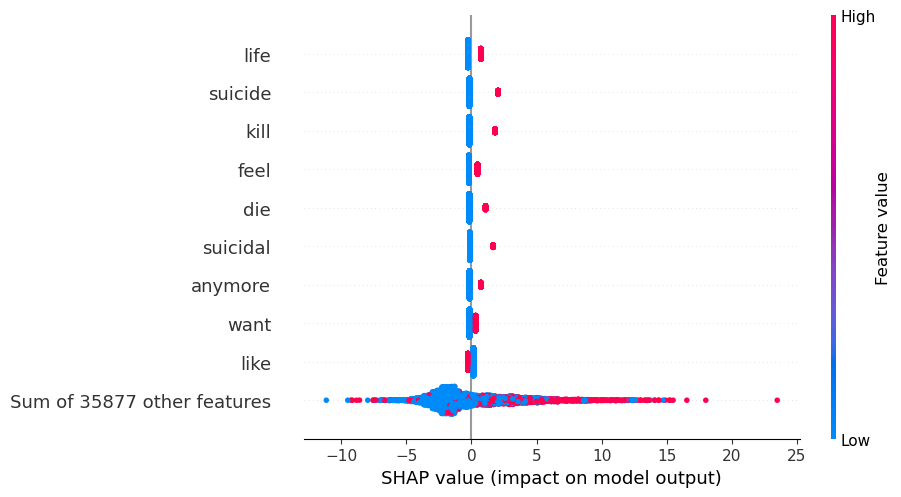

In [30]:
shap.plots.beeswarm(shap_values)

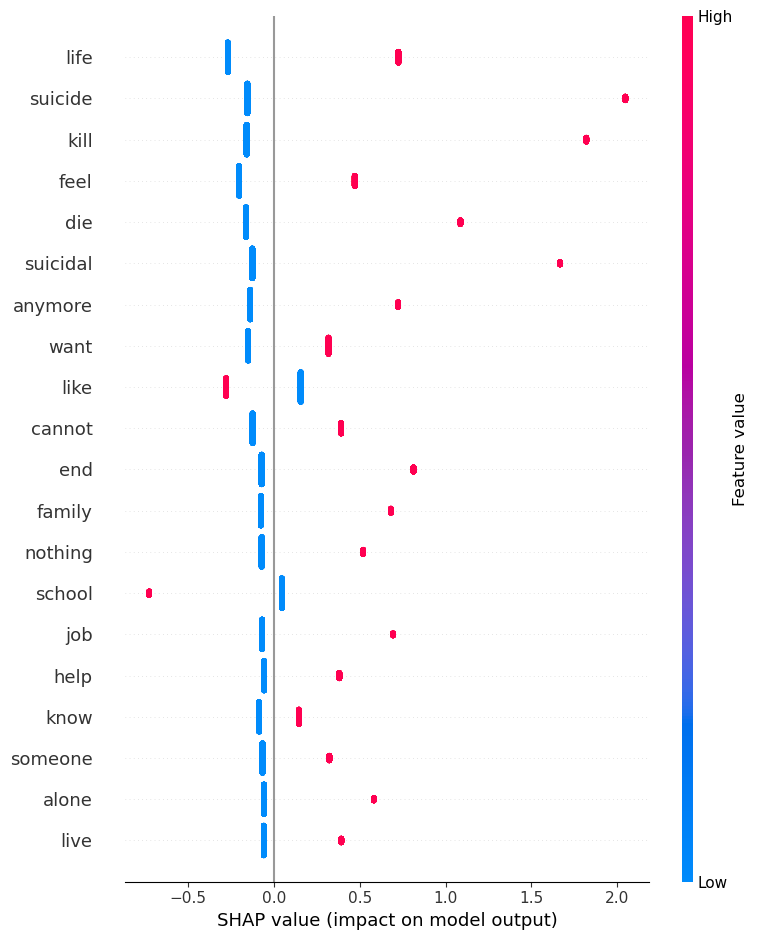

In [35]:
shap.summary_plot(shap_values)
#shap.summary_plot(shap_values[1], val_X)

In [31]:
index=200
shap.plots.force(shap_values[index])

In [32]:
index = 200  # Replace with the index you want to access
if index < len(y_test):
    print('Non-Suicide' if y_test.iloc[index] == 0 else 'Suicide', 'Text:')
    encoded_text = X_test_vec[index]
    text = vectorizer.inverse_transform(encoded_text.reshape(1, -1))
    text_str = ' '.join(text[0])
    print(text_str)
else:
    print(f"Index {index} is out of range for y_test")


Suicide Text:
better burn case convince exist forever heartbeat hell life much please scared second someone suffer take wait


In [33]:
index=4500
shap.plots.force(shap_values[index])

In [34]:
index = 4500  # Replace with the index you want to access
if index < len(y_test):
    print('Non-Suicide' if y_test.iloc[index] == 0 else 'Suicide', 'Text:')
    encoded_text = X_test_vec[index]
    text = vectorizer.inverse_transform(encoded_text.reshape(1, -1))
    text_str = ' '.join(text[0])
    print(text_str)
else:
    print(f"Index {index} is out of range for y_test")

Non-Suicide Text:
bad could gone idea jk kids last man married post update worse
